# Direct regression approach

In this case I want to get the number of corn kernels directly from the images via a regression. My plan is to use sophisticated model like VGG16 trained on a huge dataset like ImageNet as a feature extractor and then stack some linear layer to perform the regression. 


In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
#from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
# Torchvision library
import torchvision
import torch.nn as nn
from tqdm import tqdm # plot progress bars
import numpy as np

import os
import pandas as pd
#from torchvision.io import read_image
from PIL import Image
import seaborn as sns
import torch.utils.data as data
import copy


C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data adquisition  definition of the Dataset class and Dataloader

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path) # I load it as a PIL image so I can perform some transforms that are not available for tensors.
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

In [3]:
path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"

dataset = "corn"

train_csv_path  = path + f"{dataset}_coco/{dataset}_kernel_train_labels.csv" 
train_data_path = path + f"{dataset}_coco/train_set" 

test_csv_path  = path + f"{dataset}_coco/{dataset}_kernel_test_labels.csv" 
test_data_path = path + f"{dataset}_coco/test_set"


Check the label media and standard deviation to normalize it


In [4]:
df = pd.read_csv(train_csv_path)
labels = np.array(df.counts)
labels_mean = labels.mean()
labels_std = labels.std()

In [5]:
print(labels_mean)
print(labels_std)

226.48347107438016
148.264483828094


In [6]:
### I need to define some transforms for the labels of the dataset in order to perform the regression
# first we transform the labels into tensors with LabelToTensor and then we normalize the label values
# using the NormalizeLabel class

class LabelToTensor(object):
    """Convert sample to Tensors."""
    def __call__(self, sample):
        return torch.tensor(sample).float()

class NormalizeLabel(object):
    """Convert sample to Tensors."""
    def __call__(self, sample,mean=labels_mean, std=labels_std):
        normalized = (sample-mean)/std
        return torch.tensor(normalized).float()
    

In [7]:
### Define transforms
train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                         transforms.RandomHorizontalFlip(p=0.6),
                                         #torchvision.transforms.ColorJitter(),
                                         #torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                                         torchvision.transforms.RandomVerticalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Resize((224,224)),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                        ])

# The test dataset must remain as original as possible
test_transforms = transforms.Compose([transforms.ToTensor(),
                                         transforms.Resize((224,224)),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                        ])

target_transform = transforms.Compose([LabelToTensor(),
                                               NormalizeLabel(),
                                               ]) 

In [8]:
### Define dataset
train_dataset = CustomImageDataset(train_csv_path, train_data_path,
                                   transform=train_transforms,
                                   target_transform = target_transform)

test_dataset = CustomImageDataset(test_csv_path, test_data_path,
                                  transform = test_transforms,
                                  target_transform = target_transform)


Now I will split the train dataset into train and validation

In [9]:
# Split train data into train and validation sets
# (10% of training set will be used as validation set)
num_train_examples = int(len(train_dataset) * 0.90)
num_valid_examples = len(train_dataset) - num_train_examples

print(f"Number of training examples: {num_train_examples}")

Number of training examples: 217


In [10]:
# Create 'Subset' objects
train_dataset, validation_dataset = data.random_split(train_dataset, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_dataset)}")
print(f"Number validation examples: {len(validation_dataset)}")
print(f"Number test examples: {len(test_dataset)}")

Number training examples: 217
Number validation examples: 25
Number test examples: 62


In [11]:
# Apply test transformations to the validation set
validation_dataset = copy.deepcopy(validation_dataset) # If we change train transformations, this won't affect the validation set
validation_dataset.dataset.transform = test_transforms

Define the iterators

In [12]:
# data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)


C:\Users\hilar\AppData\Local\Temp\ipykernel_14924\4254983282.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(normalized).float()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLE AT INDEX 11
LABEL: 393


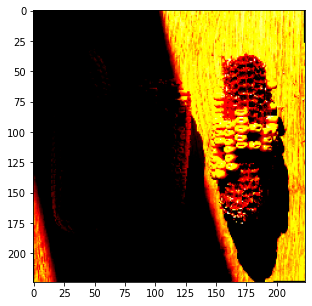

In [13]:
sample_index = 11
image = train_dataset[sample_index][0].numpy().transpose(1, 2, 0)
label = int(train_dataset[sample_index][1]*148.26+226.48) #.numpy()

fig = plt.figure(figsize=(5,5))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

# Network architecture

In [14]:
class Regressor_NN(nn.Module):
    def __init__(self, Pre_Trained_Feature_Extractor):
        super().__init__()
        
        self.features     = Pre_Trained_Feature_Extractor
        self.regressor    = nn.Sequential(    
                            nn.Flatten(),            # Flatten layer
                            nn.Linear(in_features= ((512) * 7* 7),
                                      out_features=256),
                            nn.ReLU(True),
                            nn.Dropout(0.2),
                            nn.Linear(in_features= 256,
                                      out_features=128),
                            nn.ReLU(True),
                            nn.Dropout(0.2),
                            nn.Linear(in_features= 128,
                                      out_features=64),
                            nn.ReLU(True), 
                            nn.Dropout(0.2),
                            nn.Linear(in_features=64, out_features=1,bias=False) # Second linear layer
                        )
        
    def forward(self, x,mode):
        if (mode == "Train"):
            self.features.train()
            self.regressor.train()
        elif (mode == "Test"):
            self.features.eval()
            self.regressor.eval()
        y = self.features(x)
        y = self.regressor(y)
        return y
    
    
    ### Training function
    def train_epoch(self,device,dataloader, loss_fn, optimizer, verbose = True):
        """
        This function train the network for one epoch
        """
        # Train
        train_loss = []
        for data_batched, label_batched in dataloader:
            # Move data to device
            data_batched = data_batched.to(device)
            label_batched = label_batched.to(device)
            # process
            processed = self.forward(data_batched,"Train")[:,0]
            # Compute loss
            loss = loss_fn(processed, label_batched)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            #Updata weights
            optimizer.step()
            #Save trai loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        #Save the average train loss
        train_loss = np.mean(train_loss)
        if verbose: print(f"AVERAGE TRAIN LOSS: {train_loss}")

        return train_loss

    ### Testing function
    def test_epoch(self,device, dataloader, loss_fn, verbose= True):
        """
        This function test the network performance for one epoch of training
        """
        test_loss = []
        # Discable gradient tracking
        with torch.no_grad():
            for data_batched, label_batched in dataloader:
                # Move data to device
                data_batched = data_batched.to(device)
                label_batched = label_batched.to(device)
                # process
                processed = self.forward(data_batched,"Test")[:,0]
                # Compute loss
                loss = loss_fn(processed, label_batched)
                 #Save test loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                test_loss.append(loss_batch)
            #Save the average train loss
            test_loss = np.mean(test_loss)
            if verbose: print(f"AVERAGE VALIDATION LOSS: {test_loss}")

        return test_loss
    
        
        
    def training_cycle(self, device, training_data, test_data, loss_fn, optim, num_epochs,
                       keep_model=False, verbose= True):
        """
        This function train the network for a desired number of epochs it also test the network 
        reconstruction performance and make plots comparing the input image and the reconstructed one every 5 epochs.
        """
        #I keep track of losses for plots
        train_loss = []
        test_loss  = []
        i = 0
        for epoch in tqdm(range(num_epochs)):
            if verbose: print('EPOCH %d/%d' % (epoch + 1, num_epochs))
            ### Training (use the training function)
            tr_l = self.train_epoch(
                device=device, 
                dataloader=training_data, 
                loss_fn=loss_fn, 
                optimizer=optim,
                verbose = verbose)
            train_loss.append(tr_l)
            ### Validation  (use the testing function)
            t_l = self.test_epoch(
                device=device, 
                dataloader=test_data, 
                loss_fn=loss_fn,
                verbose = verbose)
            test_loss.append(t_l)

        return train_loss, test_loss

In [15]:
VGG = torchvision.models.vgg16(pretrained = True)

In [16]:
#VGG.load_state_dict(torch.load('C:/Users/hilar/.cache/torch/hub/checkpoints/vgg16-397923af.pth'))

<All keys matched successfully>

In [16]:
model = Regressor_NN(VGG.features)

In [17]:
### Disable the weight update for the trained encoder
for param_name, param in model.features.named_parameters():
    param.requires_grad = False

### Allow weight update (training) of the last layers (linear layers)
for param in model.regressor.parameters():
    param.requires_grad = True

### Check which weights and biases will be updated
for param_name, param in model.named_parameters():
    print(param_name,param.requires_grad)

features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.17.weight False
features.17.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.24.weight False
features.24.bias False
features.26.weight False
features.26.bias False
features.28.weight False
features.28.bias False
regressor.1.weight True
regressor.1.bias True
regressor.4.weight True
regressor.4.bias True
regressor.7.weight True
regressor.7.bias True
regressor.10.weight True


In [18]:
max_epochs        = 25
learning_rate     = 1e-3

In [19]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
model.to(device)

Selected device: cpu


Regressor_NN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [20]:
train_loss, test_loss = model.training_cycle(device,
                                train_dataloader,
                                validation_dataloader,
                                loss_fn,
                                optimizer,
                                max_epochs,
                                keep_model=False,
                                verbose=True)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]C:\Users\hilar\AppData\Local\Temp\ipykernel_14924\4254983282.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(normalized).float()


EPOCH 1/25
AVERAGE TRAIN LOSS: 1.0205881595611572


  4%|███▎                                                                              | 1/25 [02:17<54:51, 137.16s/it]

AVERAGE VALIDATION LOSS: 0.8159539699554443
EPOCH 2/25
AVERAGE TRAIN LOSS: 0.7557291984558105


  8%|██████▌                                                                           | 2/25 [04:24<50:23, 131.44s/it]

AVERAGE VALIDATION LOSS: 0.6438230872154236
EPOCH 3/25
AVERAGE TRAIN LOSS: 0.7073487043380737


 12%|█████████▊                                                                        | 3/25 [06:32<47:38, 129.92s/it]

AVERAGE VALIDATION LOSS: 0.9004142880439758
EPOCH 4/25
AVERAGE TRAIN LOSS: 0.6112924218177795


 16%|█████████████                                                                     | 4/25 [08:38<44:56, 128.43s/it]

AVERAGE VALIDATION LOSS: 0.7497531175613403
EPOCH 5/25
AVERAGE TRAIN LOSS: 0.6275814175605774


 20%|████████████████▍                                                                 | 5/25 [10:43<42:19, 127.00s/it]

AVERAGE VALIDATION LOSS: 0.9669696688652039
EPOCH 6/25
AVERAGE TRAIN LOSS: 0.6949213743209839


 24%|███████████████████▋                                                              | 6/25 [12:48<40:03, 126.49s/it]

AVERAGE VALIDATION LOSS: 0.6037276983261108
EPOCH 7/25
AVERAGE TRAIN LOSS: 0.48899394273757935


 28%|██████████████████████▉                                                           | 7/25 [14:54<37:49, 126.10s/it]

AVERAGE VALIDATION LOSS: 0.9174349308013916
EPOCH 8/25
AVERAGE TRAIN LOSS: 0.36994150280952454


 32%|██████████████████████████▏                                                       | 8/25 [17:01<35:50, 126.49s/it]

AVERAGE VALIDATION LOSS: 0.5466647744178772
EPOCH 9/25
AVERAGE TRAIN LOSS: 0.4850955903530121


 36%|█████████████████████████████▌                                                    | 9/25 [19:06<33:38, 126.14s/it]

AVERAGE VALIDATION LOSS: 0.833457350730896
EPOCH 10/25
AVERAGE TRAIN LOSS: 0.42506352066993713


 40%|████████████████████████████████▍                                                | 10/25 [21:10<31:19, 125.30s/it]

AVERAGE VALIDATION LOSS: 0.624620258808136
EPOCH 11/25
AVERAGE TRAIN LOSS: 0.46250706911087036


 44%|███████████████████████████████████▋                                             | 11/25 [23:15<29:13, 125.23s/it]

AVERAGE VALIDATION LOSS: 0.627059817314148
EPOCH 12/25
AVERAGE TRAIN LOSS: 0.31991565227508545


 48%|██████████████████████████████████████▉                                          | 12/25 [25:21<27:11, 125.50s/it]

AVERAGE VALIDATION LOSS: 0.6836869120597839
EPOCH 13/25
AVERAGE TRAIN LOSS: 0.34160375595092773


 52%|██████████████████████████████████████████                                       | 13/25 [27:28<25:13, 126.09s/it]

AVERAGE VALIDATION LOSS: 0.5333251953125
EPOCH 14/25
AVERAGE TRAIN LOSS: 0.2502533793449402


 56%|█████████████████████████████████████████████▎                                   | 14/25 [29:34<23:06, 126.03s/it]

AVERAGE VALIDATION LOSS: 0.7203956842422485
EPOCH 15/25
AVERAGE TRAIN LOSS: 0.2597021460533142


 60%|████████████████████████████████████████████████▌                                | 15/25 [31:38<20:52, 125.23s/it]

AVERAGE VALIDATION LOSS: 0.6514704823493958
EPOCH 16/25
AVERAGE TRAIN LOSS: 0.2674633860588074


 64%|███████████████████████████████████████████████████▊                             | 16/25 [33:42<18:43, 124.82s/it]

AVERAGE VALIDATION LOSS: 0.6656256914138794
EPOCH 17/25
AVERAGE TRAIN LOSS: 0.24857059121131897


 68%|███████████████████████████████████████████████████████                          | 17/25 [35:47<16:41, 125.15s/it]

AVERAGE VALIDATION LOSS: 0.6602298021316528
EPOCH 18/25
AVERAGE TRAIN LOSS: 0.22593574225902557


 72%|██████████████████████████████████████████████████████████▎                      | 18/25 [37:55<14:41, 125.98s/it]

AVERAGE VALIDATION LOSS: 0.6485578417778015
EPOCH 19/25
AVERAGE TRAIN LOSS: 0.2634528577327728


 76%|█████████████████████████████████████████████████████████████▌                   | 19/25 [40:00<12:32, 125.44s/it]

AVERAGE VALIDATION LOSS: 0.7048580050468445
EPOCH 20/25
AVERAGE TRAIN LOSS: 0.19485004246234894


 80%|████████████████████████████████████████████████████████████████▊                | 20/25 [42:03<10:24, 124.89s/it]

AVERAGE VALIDATION LOSS: 0.7281404137611389
EPOCH 21/25
AVERAGE TRAIN LOSS: 0.21981556713581085


 84%|████████████████████████████████████████████████████████████████████             | 21/25 [44:09<08:21, 125.31s/it]

AVERAGE VALIDATION LOSS: 0.6468923687934875
EPOCH 22/25
AVERAGE TRAIN LOSS: 0.1913800686597824


 88%|███████████████████████████████████████████████████████████████████████▎         | 22/25 [46:25<06:25, 128.41s/it]

AVERAGE VALIDATION LOSS: 0.667783260345459
EPOCH 23/25
AVERAGE TRAIN LOSS: 0.24162158370018005


 92%|██████████████████████████████████████████████████████████████████████████▌      | 23/25 [48:32<04:15, 127.87s/it]

AVERAGE VALIDATION LOSS: 0.652758002281189
EPOCH 24/25
AVERAGE TRAIN LOSS: 0.22188372910022736


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 24/25 [50:36<02:06, 126.83s/it]

AVERAGE VALIDATION LOSS: 0.5622255206108093
EPOCH 25/25
AVERAGE TRAIN LOSS: 0.2115710973739624


100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [52:40<00:00, 126.41s/it]

AVERAGE VALIDATION LOSS: 0.5707906484603882


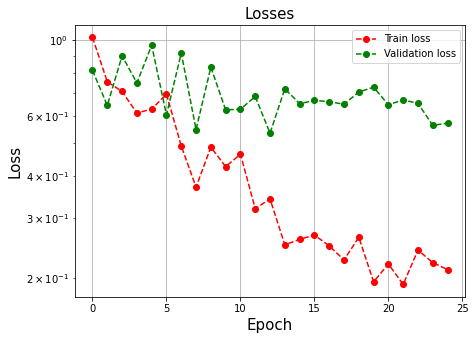

In [21]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
#plt.ylim(0,80)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

In [22]:
prediccion = []

with torch.no_grad():
    for data in test_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        # forward + backward + optimize
        outputs = model(inputs, "Test")
        outputs = outputs.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        prediccion.append([outputs[0][0],labels[0]])
prediccion = np.array(prediccion)

C:\Users\hilar\AppData\Local\Temp\ipykernel_14924\4254983282.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(normalized).float()


In [23]:
def mae(predicted,true):
    if len(predicted)!=len(true): 
        print("The list have a different size")
        return
    result = np.sum(abs(predicted-true))/len(predicted)
    return result

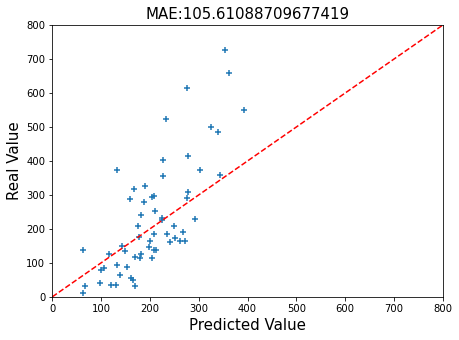

In [24]:
plt.figure(figsize=(7,5))
plt.scatter(outputs[:,0]*labels_std+labels_mean,labels*labels_std+labels_mean, marker="+",label= "Sort of confussion plot")
plt.plot(np.linspace(0, 800, num=1000),np.linspace(0, 800, num=1000), linestyle='--', color='r', label='Train loss')
plt.ylim(0,800)
plt.xlim(0,800)
plt.xlabel('Predicted Value',fontsize=15)
plt.ylabel('Real Value',fontsize=15)
plt.title(f"MAE:{mae(outputs[:,0]*labels_std+labels_mean,labels*labels_std+labels_mean)}",fontsize=15)
plt.show()


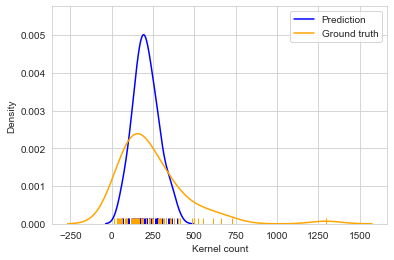

In [25]:
sns.set_style('whitegrid')
sns.kdeplot(outputs[:,0]*148.26+226.48,
             color = 'blue',
             label="Prediction")
sns.rugplot(outputs[:,0]*148.26+226.48,color = 'blue')
sns.kdeplot(labels*148.26+226.48,
             color = 'orange',
             label="Ground truth")
sns.rugplot(labels*148.26+226.48,color = 'orange')

# Plot formatting
#plt.title('Density Plot with Rug Plot for kernel count')
plt.xlabel('Kernel count')
plt.ylabel('Density')
plt.legend()
plt.show()


In [16]:
alexnet = torchvision.models.alexnet(pretrained = True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\hilar/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [01:51<00:00, 2.19MB/s] 


In [19]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
resnet18 = torchvision.models.resnet18(pretrained=True)
#resnet18.fc = nn.Linear(resnet18.fc.in_features, OUTPUT_DIM)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\hilar/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:18<00:00, 2.50MB/s]


In [22]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
densenet = torchvision.models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\hilar/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:50<00:00, 2.28MB/s] 


In [24]:
print(densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
## Uncomment the following lines to use the networks as feature extractors
## training only the last FC layer.

for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc.weight.requires_grad = True
resnet18.fc.bias.requires_grad = True

